# Семинар 3. Повторение лекции. Свёртка. Свёрточные сети 🐍

# Сегодня на занятии:
- Пятиминутка
- Повторение лекции:
  - SGD, SGD с моментом, Adam
  - BatchNorm
- Свёртка
  - Что такое свёртка
  - Сложность свёртки
  - Depthwise-свёртка
  - Связь свертки с fc-слоем
  - Обратное распространение ошибки для  fc-слоя и сверточного слоя
- Свёрточные сети
- MaxPool, AvgPool

## Пятиминутка

1. Что такое метрика?
2. Приведите пример метрики для задачи классификации
3. Пример метрики для задачи регрессии
4. Что такое функция потерь и для чего она нужна?
5. Какая функция потерь используется для задачи классификации? Напишите ее формулу
6. Почему `accuracy` может быть плохой метрикой, в чем ее недостатки?
7. Напишите формулу для полносвязного слоя
8. Что такое батч?

## Повторение

### SGD

Так как память видеокарты ограничена, используем мини-батчи. Их пропускаем через сеть, считаем градиент и усредняем по мини-батчу, а затем обновляем веса.

### SGD с моментом

Формула экспоненциального среднего для шумных данных:

$$V_t = \beta V_{t-1} + (1-\beta) S_t$$ где $S_t$ - это переменная с выбросами

![](images/0.png)

Т.к. $\beta < 1$, $\beta^n → 0$ и мы "забываем" старые значения

Чем ближе $\beta$ к нулю, тем быстрее забываем

![](images/2.png)

для подсчета гладкой переменной $V_t$ используется порядка $\frac{1}{1-\beta}$ точек

![](images/1.png)

In [1]:
import matplotlib.pyplot as plt


def exponential_average(S, beta=0.9):
    V = [0] * len(S)
    for i in range(len(S)):
        if i == 0:
            V[i] = (1 - beta) * S[i]
        else:
            V[i] = beta * V[i-1] + (1 - beta) * S[i]
    return V

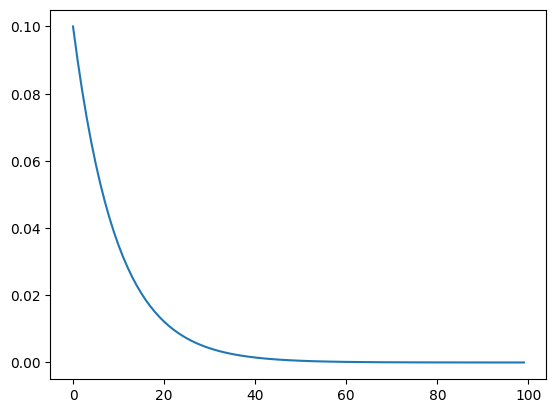

In [2]:
S = [0] * 100
S[0] = 1

V = exponential_average(S, beta=0.9)
plt.plot(V)

Применительно к обучению нейронных сетей (встречаются разные записи этой формулы, которые сводятся друг к другу переобозначениями):

![](images/3.png)

что эквивалентно:

![](images/4.png)

Из-за накопительного эфффекта (суммирования градиента по $\frac{1}{1-\beta}$ предыдущим точкам) SGD с моментом позволяет выбираться из локальных минимумов, в отличие от SGD без момента

### RMSprop

![](images/5.png)

Пусть у нас есть два параметра в сети - $w$ и $b$ - и мы хотим замедлить обучение в направлении $b$ и ускорить в направлении $w$. Накопим с помощью экспоненциального среднего квадраты градиентов $w$ и $b$ и модифицируем формулу для градиентного спуска. Теперь параметр, для которого получался большой градиент, будет обновляться медленно (мы делим на большую величину в знаменателе). А параметр, для которого получался маленький градиент, будет обновляться быстрее. Получилась адаптивная скорость обучения



### Adam

Объединим две идеи:
- использовать не градиент на конкретном шаге, а экспоненциальное среднее $m_t$, как в SGD с моментом;
- использовать адаптивность `learning rate`, как в RMSprop - делить на корень из среднего квадрата градиента $g^2_t$;

Формула будет выглядеть так:

$$W_t = W_{t-1} - α \frac{m_t}{\sqrt{g^2_t + ϵ}}$$

## BatchNorm

- Для улучшения сходимости мы нормируем данные (картинки) перед тем, как скормить их нейронке. Когда у данных предсказуемое среднее и дисперсия, сети легко обучаться
- Та же логика справедлива для каждого слоя, а не только для первого
- Среднее и дисперсия, которые получаются у данных после батчнорма, это не обязательно 0 и 1. Вообще это у нас тренируемые параметры

Плюсы батчнорма:
1. Ускоряет и стабилизирует тренировку
2. Инициализация весов не так важна
3. Регуляризует (так как сэмплы в батче нормируются на среднее по батчу)

Формула:

$$x\prime^{(k)} = \frac{x^{(k)} - \mu^{(k)}}{\sqrt{\sigma^{(k)2}+\epsilon}} \gamma^{(k)} + \beta^{(k)}$$

- Нормировка для каждой фичи отдельная
- Два режима работы
- В `train` режиме:
  - Когда приходит на вход батч, нормируем по нему данные и пропускаем дальше
  - Учим параметры $\gamma^{(k)}$ и $\beta^{(k)}$ - "новые" станд. отклонения и средние для данных
  - Запоминаем $\mu^{(k)}$ и $\sigma^{(k)2}$, которые в среднем встречались у нас во время обучения (экспоненциальные средние от параметров по батчам)
- В `eval` режиме:
  - Просто используем $\mu^{(k)}$ и $\sigma^{(k)2}$, которые мы запомнили, и $\gamma^{(k)}$ и $\beta^{(k)}$, которые мы обучили. То есть на валидации `BatchNorm` превращается просто в линейный слой
- Не стоит использовать с очень маленьким размером батча

# Свертка

In [ ]:
from typing import Tuple
from random import randrange
import inspect

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

**Определение:**

Пусть $X$ - это входное $c$-канальное изображение, $W$ - это ядро свёртки (четырёхмерный тензор размера $(k_x, k_y, c, c\prime$). Тогда результат свёртки $O$ вычисляется по формуле:

$$O_{xyc\prime} = \sum_{ijc} W_{i,j,c,c\prime} X_{x+i,y+j,c}$$

### Производная по fc-слою

Пусть $y$ - это выход fc-слоя: $y_{ij} = x_{ik} W_{kj} + b_{ij}$, $f$ - это функция $y$

$$\frac{\partial f}{\partial W_{ml}} = \frac{\partial f}{\partial y_{ij}} \frac{\partial y_{ij}}{\partial W_{ml}} = \frac{\partial f}{\partial y_{ij}} x_{ik} \delta_{km} \delta_{jl} = \frac{\partial f}{\partial y_{il}} x_{im}$$

*Упражнение: посчитать производные по $x_{ml}$ и по $b_{ml}$, f = MSE(y, 0)*

### Производная по conv-слою

Сверточный слой можно свести к полносвязному. Пусть есть картинка 3x3 с одним каналом:

\begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9 \\
\end{bmatrix}

и свертка (2, 2, 1, 1):

\begin{bmatrix}
0 & 1 \\
-1 & 2 \\
\end{bmatrix}

Для расчета результата в точке (0, 0) можно представить операцию свертки как произведение матрицы изображения:

\begin{bmatrix}
1 & 2 & 4 & 5 \\
\end{bmatrix}

на матрицу весов:

\begin{bmatrix}
0 \\
1 \\
-1 \\
2 \\
\end{bmatrix}

И считать backprop как для обычного перемножения матриц

*Упражнение: рассмотрите случай с изображением и сверткой для нескольких каналов и выведите общую формулу*

### torch.nn.Conv2d

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [ ]:
inspect.signature(nn.Conv2d.__init__)

<Signature (self, in_channels: int, out_channels: int, kernel_size: Union[int, Tuple[int, int]], stride: Union[int, Tuple[int, int]] = 1, padding: Union[str, int, Tuple[int, int]] = 0, dilation: Union[int, Tuple[int, int]] = 1, groups: int = 1, bias: bool = True, padding_mode: str = 'zeros', device=None, dtype=None) -> None>

- **stride** управляет шагом
- **padding** управляет количеством неявных отступов с обеих сторон
- **dilation** контролирует расстояние между точками ядра


Визуализация параметров **Conv2d**: https://github.com/vdumoulin/conv_arithmetic

### Примеры фильтров

In [ ]:
image = Image.open('images/Lena.jpg')

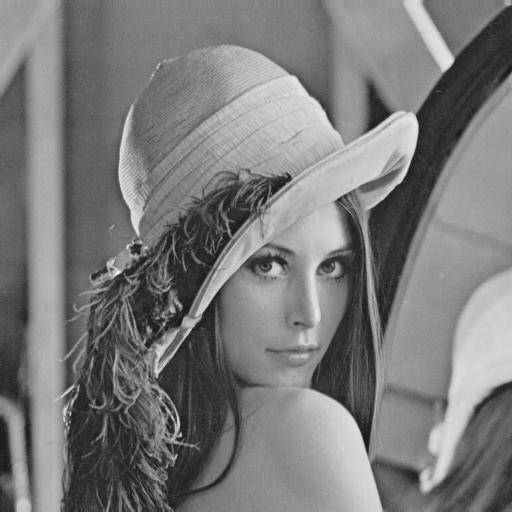

In [ ]:
image

In [ ]:
image = transforms.ToTensor()(image).unsqueeze(0)
image.shape

torch.Size([1, 1, 512, 512])

***

Prewitt kernel (along x-axis):

$
K =
\begin{bmatrix}
    -1 & 0 & 1 \\
    -1 & 0 & 1 \\
    -1 & 0 & 1 \\
\end{bmatrix}
$

In [ ]:
kernel_Prewitt_x = torch.Tensor([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1],
])

In [ ]:
def create_conv(kernel):
    conv = torch.nn.Conv2d(
        in_channels=1,
        out_channels=1,
        kernel_size=(kernel.shape[0], kernel.shape[1]),
    )

    conv.weight.data = kernel.reshape(1, 1, kernel.shape[0], kernel.shape[0])
    conv.bias.data = torch.Tensor([0])
    
    return conv

In [ ]:
conv_Prewitt_x = create_conv(kernel_Prewitt_x)

In [ ]:
image_filtered = conv_Prewitt_x(image)

In [ ]:
def normalize_image(image):
    min_intensity = torch.min(image)
    image = image - min_intensity
    max_intensity = torch.max(image)
    return image / max_intensity

In [ ]:
def tensor_to_PIL(tensor):
    return transforms.ToPILImage()(normalize_image(tensor).squeeze(0))

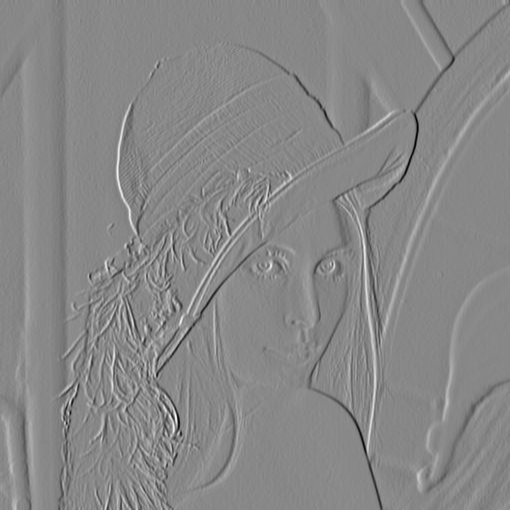

In [ ]:
tensor_to_PIL(image_filtered)

***

Prewitt kernel (along y-axis):

$
K =
\begin{bmatrix}
    -1 & -1 & -1 \\
    0 & 0 & 0 \\
    1 & 1 & 1 \\
\end{bmatrix}
$

In [ ]:
kernel_Prewitt_y = torch.Tensor([
    [-1, -1, -1],
    [ 0,  0,  0],
    [ 1,  1,  1],
])

In [ ]:
conv_Prewitt_y = create_conv(kernel_Prewitt_y)

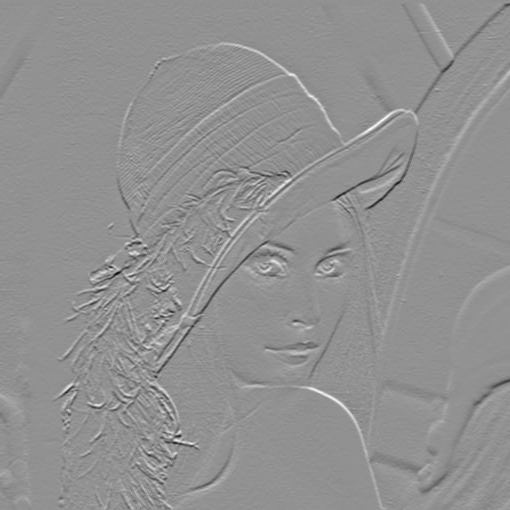

In [ ]:
tensor_to_PIL(conv_Prewitt_y(image))

***

Blur kernel

$
K = \frac{1}{9}
\begin{bmatrix}
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1 \\
\end{bmatrix}
$

In [ ]:
rad = 9
conv_blur = create_conv(torch.ones((rad, rad)) / rad ** 2)

In [ ]:
conv_blur.weight.shape

torch.Size([1, 1, 9, 9])

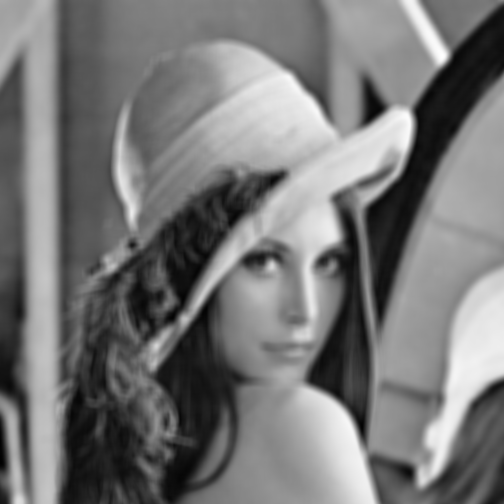

In [ ]:
tensor_to_PIL(conv_blur(image))

***

### Детекция объекта при помощи свертки

In [ ]:
canvas = torch.zeros((512, 512))

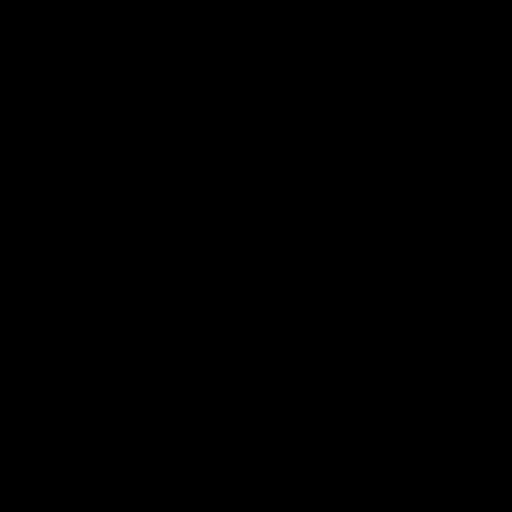

In [ ]:
tensor_to_PIL(canvas)

In [ ]:
def circle(rad) -> torch.Tensor:
    width = 5
    diameter = 2 * rad
    canvas = torch.zeros((diameter, diameter))
    for i in range(diameter):
        for j in range(diameter):
            left_side = (i - rad) ** 2 + (j - rad) ** 2
            if left_side <= rad ** 2 and left_side >= (rad - width) ** 2:
                canvas[i, j] = 1
    return canvas

def square(size) -> torch.Tensor:
    width = 5
    canvas = torch.ones((size, size))
    inner = torch.zeros((size - 2 * width, size - 2 * width))
    canvas[width : size - width, width : size - width] = inner
    return canvas

In [ ]:
one_circle = circle(64)
one_square = square(150)

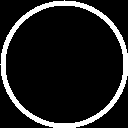

In [ ]:
tensor_to_PIL(one_circle)

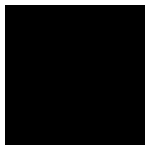

In [ ]:
tensor_to_PIL(one_square)

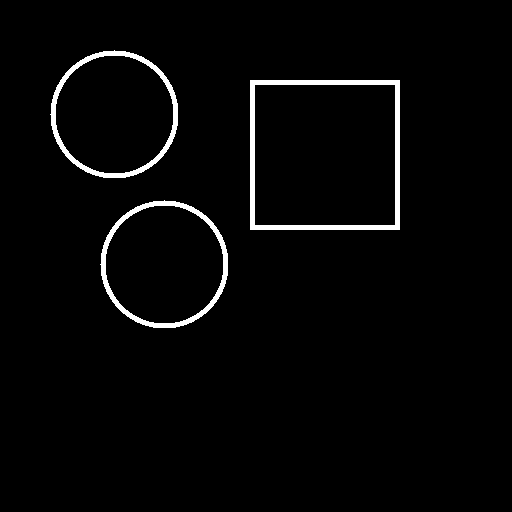

In [ ]:
canvas[50 : 50 + 128, 50 : 50 + 128] = one_circle
canvas[200 : 200 + 128, 100 : 100 + 128] = one_circle
canvas[80 : 80 + 150, 250 : 250 + 150] = one_square
tensor_to_PIL(canvas)

In [ ]:
circle_detect = create_conv(one_circle)

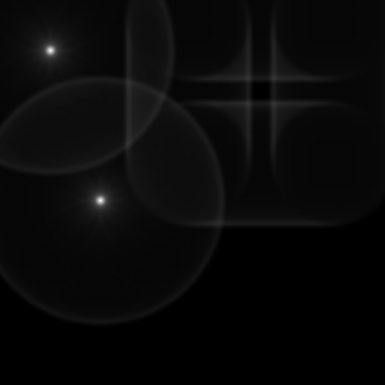

In [ ]:
tensor_to_PIL(circle_detect(canvas.unsqueeze(0).unsqueeze(0)))

***

# Сверточные сети

### Классификация на основе сверточной сети

In [ ]:
class ConvolutionNetwork(nn.Module):
    def __init__(
        self, 
        img_size: Tuple[int, int] = (1, 28, 28),  # (кол-во каналов, высота px, ширина px)
        num_classes: int = 10,
    ):
        super().__init__()
        in_channels = img_size[0]
        height = img_size[1]
        width = img_size[2]
                
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1)
        self.fc3 = nn.Linear(in_features=16 * height * width, out_features=num_classes)
        
    def forward(self, x: torch.Tensor):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc3(x)
        
        return x

In [ ]:
model = ConvolutionNetwork()

In [ ]:
[(name, parameter.shape) for name, parameter in model.named_parameters()]

[('conv1.weight', torch.Size([8, 1, 3, 3])),
 ('conv1.bias', torch.Size([8])),
 ('conv2.weight', torch.Size([16, 8, 3, 3])),
 ('conv2.bias', torch.Size([16])),
 ('fc3.weight', torch.Size([10, 12544])),
 ('fc3.bias', torch.Size([10]))]

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.5],
        std=[0.5],
    ),
])

In [ ]:
# FashionMNIST: https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html
train_dataset = torchvision.datasets.FashionMNIST(
    root='datasets',
    download=True,
    train=True,
    transform=transform,
)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=4,
)

In [ ]:
valid_dataset = torchvision.datasets.FashionMNIST(
    root='datasets',
    download=True,
    train=False,
    transform=transform,
)

valid_dataloader = torch.utils.data.DataLoader(
    dataset=valid_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=4,
)

In [ ]:
batch, _ = next(iter(train_dataloader))

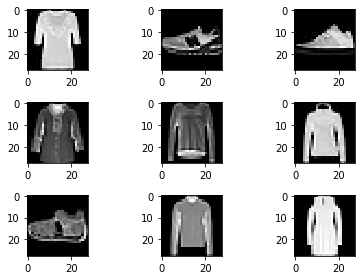

In [ ]:
figure = plt.figure()

for index in range(9):
    plt.subplot(3, 3, index + 1)
    plt.tight_layout()
    plt.imshow(batch[index][0], cmap='gray', interpolation='none')

In [ ]:
criterion = nn.CrossEntropyLoss()  # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

optimizer = torch.optim.SGD(
    params=model.parameters(),
    lr=0.01,
    momentum=0.9,
)


def train_step() -> float:
    model.train()
    
    running_loss = 0.
    for images, labels in train_dataloader:
        
        # Удаляем накопленные ранее градиенты.
        # parameter.grad = 0
        optimizer.zero_grad()
        
        # Делаем проход (forward pass).
        # Состояние модели `train` обеспечивает сохранение промежуточных результатов вычислений.
        # Эти сохраненные значения будут использованы ниже для вычисления градиента функции потерь.
        output = model(images)
        
        # Вычисляем функцию потерь на основе предсказания модели.
        loss = criterion(output, labels)

        # Вычисляем градиент: направление, в котором функция потерь возрастает максимально быстро.
        # parameter.grad += dloss / dparameter
        loss.backward()

        # parameter += -lr * parameter.grad
        # 
        # PyTorch SGD:
        # velocity = momentum * velocity + parameter.grad
        # parameter += - lr * velocity
        optimizer.step()
        
        # Накапливаем статистику.
        running_loss += loss
    
    with torch.no_grad():
        train_loss = running_loss / len(train_dataloader)
    return train_loss.item()


def valid_step() -> Tuple[float, float]:
    model.eval()

    correct_total = 0.
    running_loss = 0.
    with torch.no_grad():
        for images, labels in valid_dataloader:
            
            output = model(images)
            
            prediction = output.argmax(dim=1)
            correct_total += prediction.eq(labels.view_as(prediction)).sum()
            
            loss = criterion(output, labels)
            running_loss += loss
        
    valid_loss = running_loss / len(valid_dataloader)
    accuracy = correct_total / len(valid_dataloader.dataset)
    return valid_loss.item(), accuracy.item()

In [ ]:
train_losses = []
valid_losses = []
valid_accs = []

In [ ]:
epochs = 20

for _ in (pbar := tqdm(range(epochs))):
    train_loss = train_step()
    valid_loss, valid_acc = valid_step()
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    pbar.set_description(f'Avg. train/valid loss: {train_loss:.4f}/{valid_loss:.4f}')

Avg. train/valid loss: 0.1571/0.2790: 100%|████████████████████████████████████████████████████████████| 20/20 [01:41<00:00,  5.06s/it]


Text(0, 0.5, 'Loss')

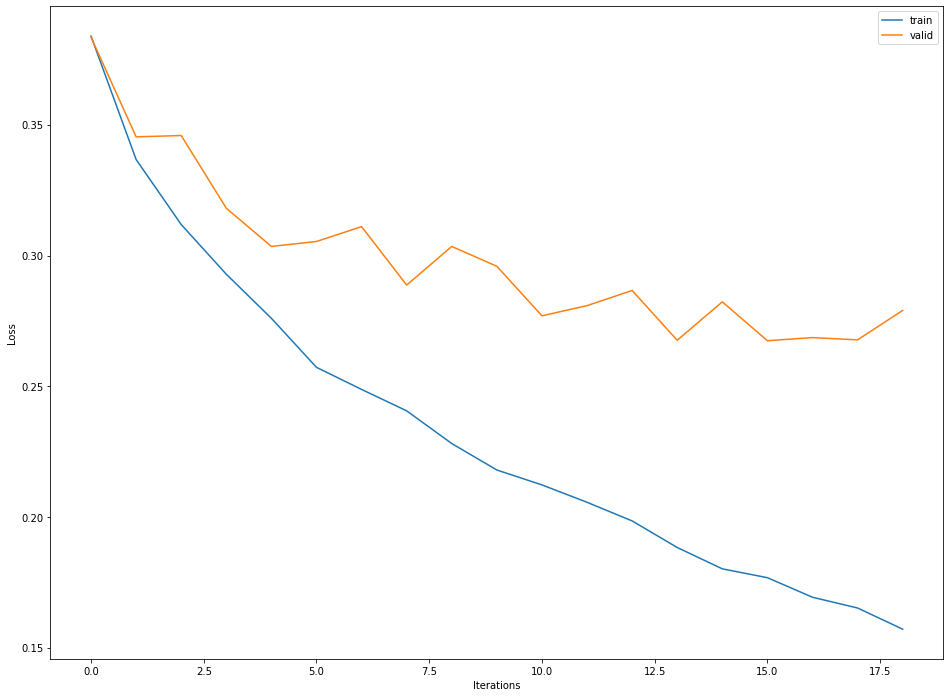

In [ ]:
fig = plt.figure(figsize=(16, 12))

plt.plot(train_losses[1:], label='train')
plt.plot(valid_losses[1:], label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

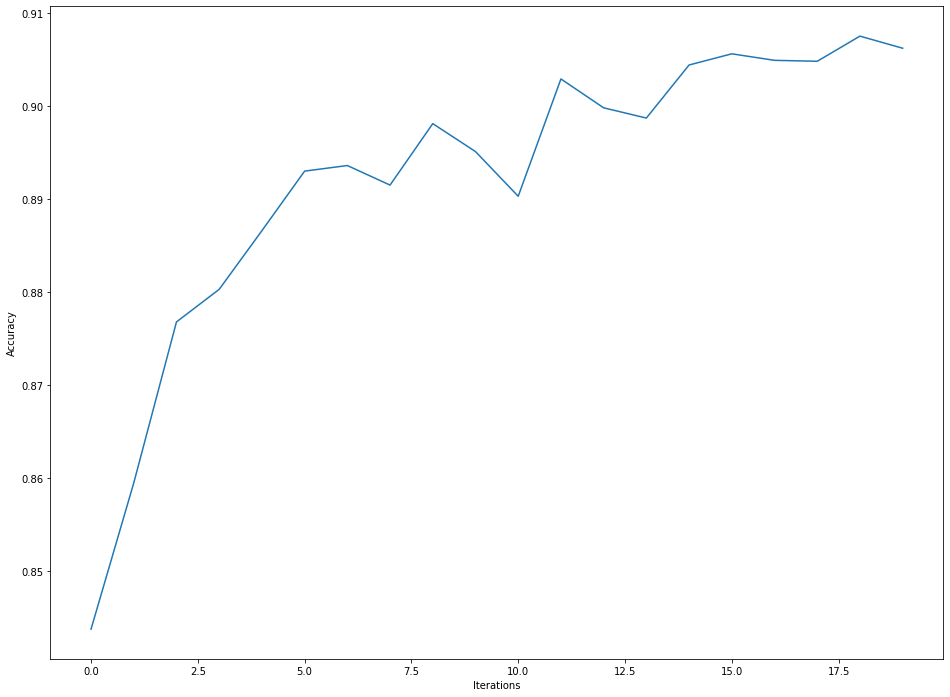

In [ ]:
fig = plt.figure(figsize=(16, 12))

plt.plot(valid_accs)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

***

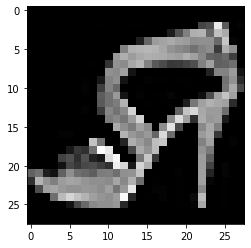

In [ ]:
batch, _ = next(iter(train_dataloader))
sample = batch[randrange(0, 255)]
plt.imshow(sample[0], cmap='gray', interpolation='none')

In [ ]:
prediction = model(sample.unsqueeze(dim=0))

In [ ]:
prediction

tensor([[  5.0192,  -4.2893,  -1.3038,  -4.6998, -10.0797,  15.9339,  -1.7565,
          -5.9779,   6.6843,   1.1977]], grad_fn=<AddmmBackward0>)

In [ ]:
mapping = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
}

In [ ]:
mapping[prediction.argmax(dim=1).item()]

'Sandal'